In [10]:
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

<h1 style="background-color:rgb(181 ,50 ,84);color:white;text-align:center">Generalized Integrate-and-fire model</h1>

The standard leaky integrate-and-fire model is rather limited in scope, since it has one universal voltage threshold. Nonlinear integrate-and-fire neurons, however, can account for the fact that in real neurons the effective voltage threshold for repetitive firing is different than the voltage threshold found with short current pulses. These two voltage thresholds, which are related to the minimum of the nonlinearity $f(u)$ and to the unstable fixed point, respectively, are intrinsic features of nonlinear integrate-and-fire models. Once the membrane potential is above the intrinsic threshold, the upswing of the membrane potential starts. The integration is stopped at a numerical threshold $θ_{reset}$  which is much higher and conceptually very different than the intrinsic firing threshold of the model. In fact, the exact value of the numerical threshold does not matter, since, without such a threshold, the membrane potential would go to infinity in finite time.

In a general nonlinear integrate-and-fire model with a single variable $u$ the membrane potential evolves according to: $$\tau \frac{d}{dt}u = f(u)+RI$$

In [13]:
# typical neuron parameters#
u_rest = -75.   # reset potential [mV]
tau_m = 10.     # membrane time constant [ms]
g_L = 10.       # leak conductance [nS]

# Simulation parameters 
T = 40.  # Total duration of simulation [ms]
dt = .1   # Simulation time step [ms]

# Time vector
t = np.arange(0, T+dt, dt)

In [46]:
def plot_state(t, I, u_t):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(t, I, label='Input Current')
    ax[0].set_ylabel('I (nA)')
    ax[0].set_xlabel('Time (ms)')
    ax[0].legend()

    ax[1].plot(t, u_t, label='Membrane Potential')

    ax[1].set_ylabel('u (mV)')
    ax[1].set_xlabel('Time (ms)')
    ax[1].legend()

    plt.show()

### Exponential Integrate-and-fire model

In the exponential integrate-and-fire model the differential equation for the membrane potential is given by: $$\tau \frac{d}{dt}u = -(u-u_{rest})+\Delta_T\exp\bigg(\frac{u-\vartheta_{rh}}{\Delta_T}\bigg) + RI$$

The moment when the membrane potential reaches the numerical threshold $\theta_{reset}$ defines the firing time $t(f)$. After firing, the membrane potential is reset to $u_r$ and integration restarts at time $t(f)+\Delta^{abs}$ where $\Delta^{abs}$ is an absolute refractory time, typically chosen in the range $0<\Delta^{abs}<5ms$. If the numerical threshold is chosen sufficiently high, $\theta_{reset}>>\vartheta_{rh}+\Delta_T$, its exact value does not play any role. The reason is that the upswing of the action potential for $u>>\vartheta_{rh}+\Delta_T$ is so rapid, that it goes to infinity in an incredibly short time. The threshold $\theta_{reset}$ is introduced mainly for numerical convenience. For a formal mathematical analysis of the model, the threshold can be pushed to infinity.

In [5]:
class ExpLIF():
    def __init__(self, u_rest, tau, R, Delta_T, t_rh):
        self.u_rest = u_rest
        self.tau = tau
        self.R = R
        self.Delta_T = Delta_T
        self.t_rh = t_rh

    def u_dot(self, u, i):
        return (self.u_rest - u + self.Delta_T*np.exp((u - self.t_rh)/self.Delta_T) + self.R*i) / self.tau

    def simulate(self, t_range, dt, I):
        u_t = np.zeros_like(t_range)
        u_t[0] = self.u_rest

        rec_spikes = []

        for i in range(len(t_range) - 1):
            if u_t[i] >= 100:
                u_t[i] = self.u_rest
                rec_spikes.append(t_range[i])
            
            u_t[i+1] = u_t[i] + dt*self.u_dot(u_t[i], I[i])

        return u_t, rec_spikes

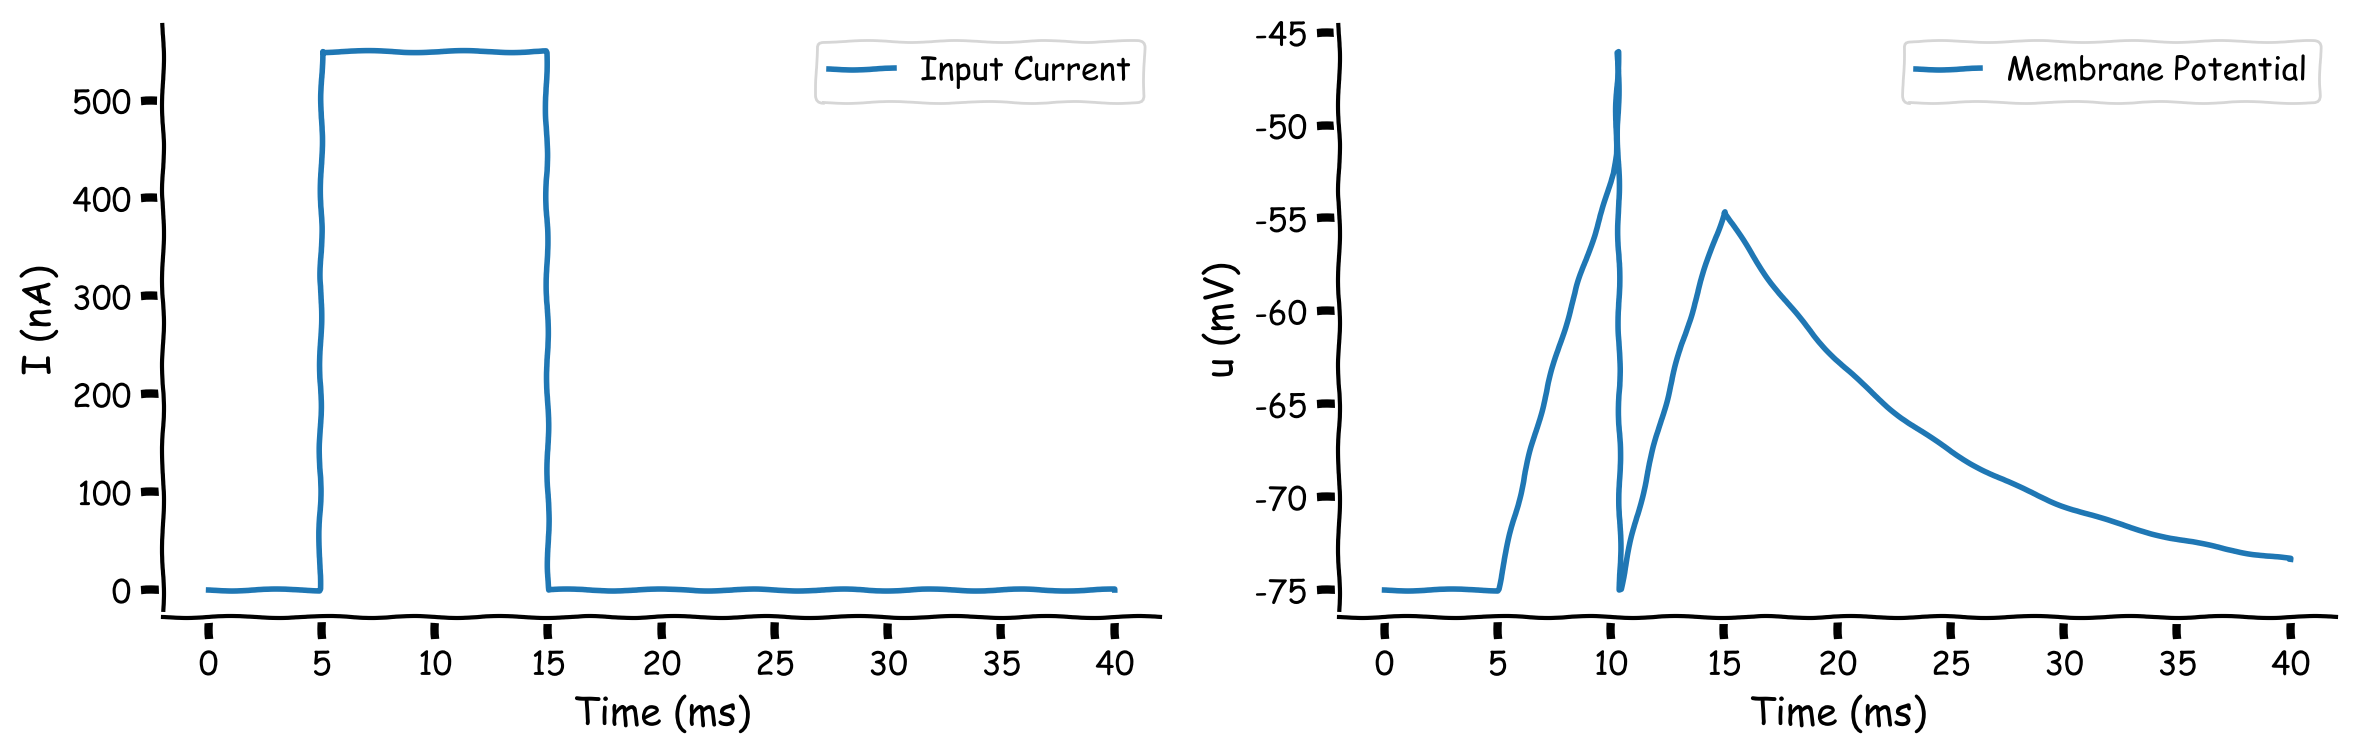

In [58]:
# Simulation example
lif_neuron = ExpLIF(u_rest, tau_m, 1/g_L, 0.5, -55)

I = np.zeros_like(t)
I[int(5/dt):int(15/dt)] = 550

u_t, rec_spikes = lif_neuron.simulate(t, dt, I)

# Plot
with plt.xkcd():
    plot_state(t, I, u_t)

##### Threshold voltage

In [50]:
### Pulse input
lif_neuron = ExpLIF(u_rest, tau_m, 1/g_L, 0.5, -55)

I = np.zeros_like(t)
I[int(5/dt):int(10/dt)] = 500
rec_spikes = []
u_t = np.zeros_like(t)

while len(rec_spikes) == 0:
    threshold = max(u_t)
    I[int(5/dt):int(10/dt)] += 1
    u_t, rec_spikes = lif_neuron.simulate(t, dt, I)
    
print(threshold)


-53.14971369490124


In [59]:
### Constant input
lif_neuron = ExpLIF(u_rest, tau_m, 1/g_L, 0.5, -55)

I = np.zeros_like(t)
I[:] = 200
rec_spikes = []
u_t = np.zeros_like(t)

while len(rec_spikes) == 0:
    threshold = max(u_t)
    I[int(5/dt):int(10/dt)] += 1
    u_t, rec_spikes = lif_neuron.simulate(t, dt, I)
    
print(threshold)

-51.55206256498277


### Quadratic Integrate-and-fire model

A specific instance of a nonlinear integrate-and-fire model is the quadratic model: $$\tau \frac{d}{dt}u = a_0(u-u_{rest})(u-u_c) + RI$$

In [60]:
class QuadLIF():
    def __init__(self, u_rest, tau, R, a0, uc):
        self.u_rest = u_rest
        self.tau = tau
        self.R = R
        self.a0 = a0
        self.uc = uc

    def u_dot(self, u, i):
        return (self.a0 * (u - self.u_rest)*(u - self.uc) + self.R*i) / self.tau

    def simulate(self, t_range, dt, I):
        u_t = np.zeros_like(t_range)
        u_t[0] = self.u_rest

        rec_spikes = []

        for i in range(len(t_range) - 1):
            if u_t[i] >= 100:
                u_t[i] = self.u_rest
                rec_spikes.append(t_range[i])
            
            u_t[i+1] = u_t[i] + dt*self.u_dot(u_t[i], I[i])

        return u_t, rec_spikes

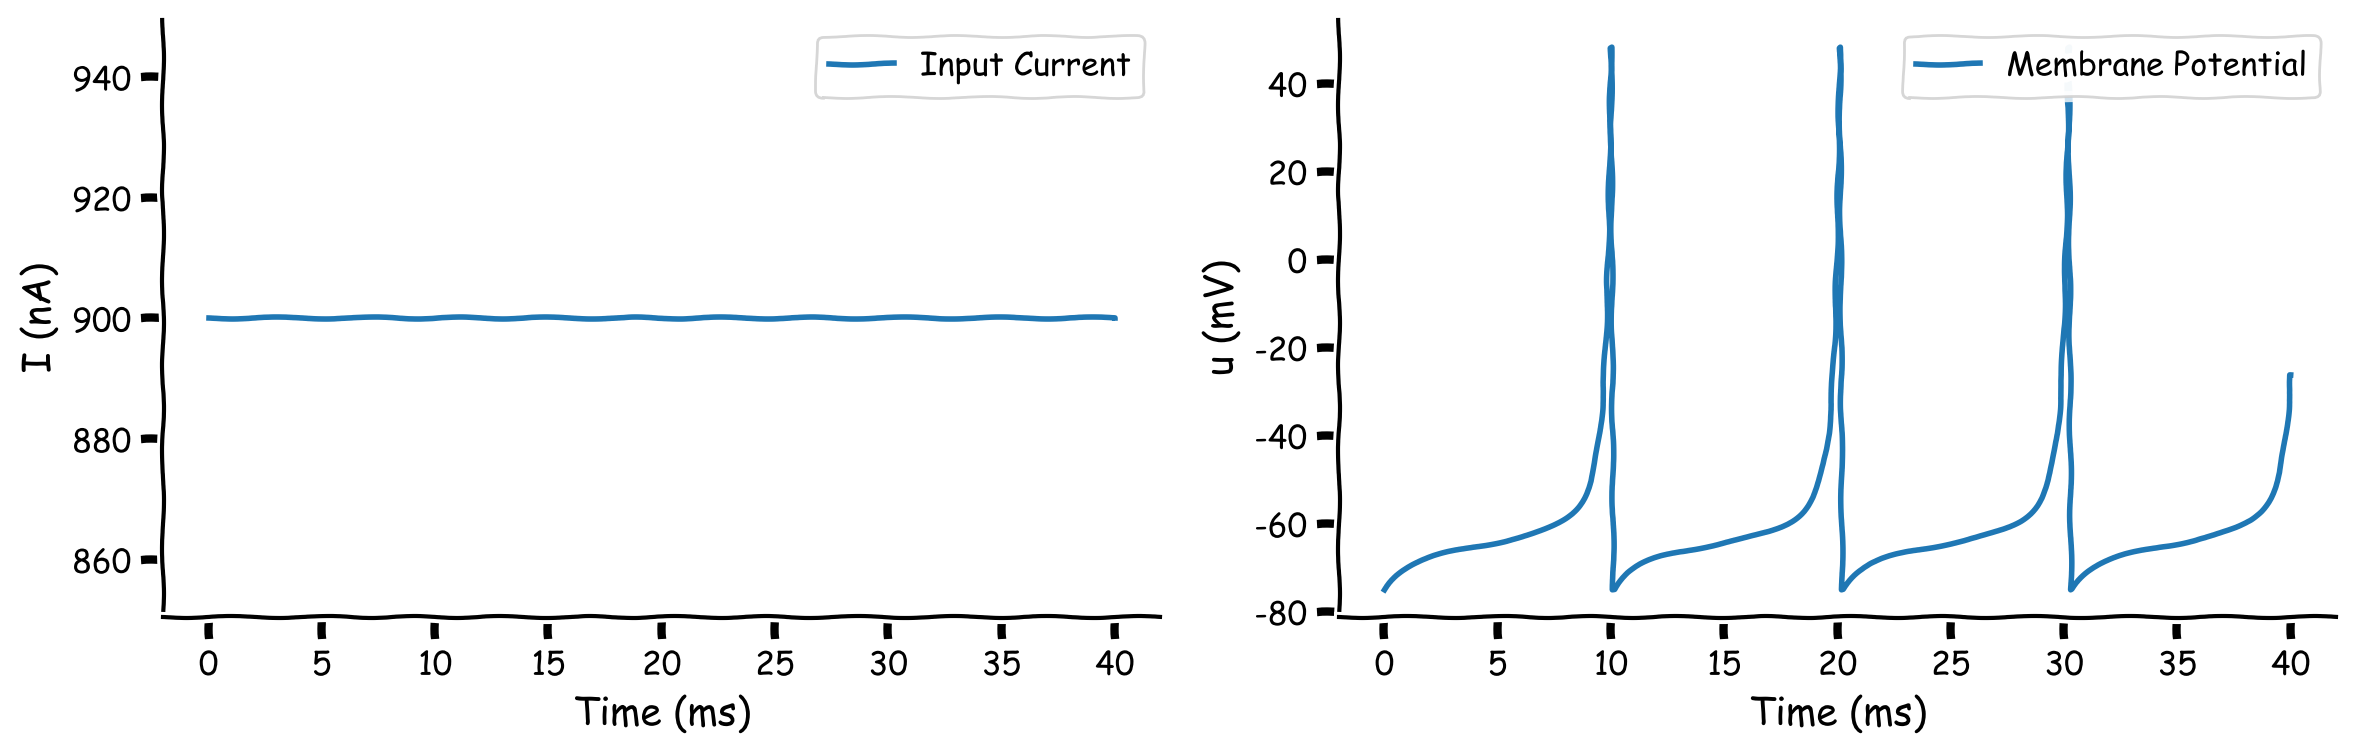

In [84]:
# Simulation example
lif_neuron = QuadLIF(u_rest, tau_m, 1/g_L, 0.8, -55)

I = np.zeros_like(t)
I[:] = 900

u_t, rec_spikes = lif_neuron.simulate(t, dt, I)

# Plot
with plt.xkcd():
    plot_state(t, I, u_t)

#### Threshold voltage

In [90]:
### Pulse input
lif_neuron = QuadLIF(u_rest, tau_m, 1/g_L, 0.8, -55)

I = np.zeros_like(t)
I[int(5/dt):int(10/dt)] = 500
rec_spikes = []
u_t = np.zeros_like(t)

while len(rec_spikes) == 0:
    threshold = max(u_t)
    I[int(5/dt):int(10/dt)] += 1
    u_t, rec_spikes = lif_neuron.simulate(t, dt, I)
    
print(threshold)

-55.085935557073725


In [91]:
### Constant input
lif_neuron = QuadLIF(u_rest, tau_m, 1/g_L, 0.8, -55)

I = np.zeros_like(t)
I[:] = 800
rec_spikes = []
u_t = np.zeros_like(t)

while len(rec_spikes) == 0:
    threshold = max(u_t)
    I[:] += 1
    u_t, rec_spikes = lif_neuron.simulate(t, dt, I)
    
print(threshold)

-48.85001868360687
